In [ ]:
!pip install spacy --upgrade  #upgrade spacy

Requirement already up-to-date: spacy in /usr/local/lib/python3.7/dist-packages (3.0.6)


In [ ]:
%%bash
python -m spacy download en

  Found existing installation: en-core-web-sm 2.2.5
    Uninstalling en-core-web-sm-2.2.5:
      Successfully uninstalled en-core-web-sm-2.2.5
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


2021-06-17 05:13:13.409678: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [ ]:
#calling heavenly gods -- import all the necessary packages
import os
import glob
import torch
import torch
import torch.nn as nn
import torch.optim as optim


from torchtext.legacy.data import Field, BucketIterator
from torchtext.legacy import data
import torchtext

import spacy
import numpy as np

import random
import math
import time

import os  # when loading file paths
import pandas as pd  # for lookup in annotation file
import spacy  # for tokenizer
import torch
from torch.nn.utils.rnn import pad_sequence  # pad batch
from torch.utils.data import DataLoader, Dataset



In [ ]:
# set the seed

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
# read the data
df = pd.read_csv('/content/quora_duplicate_questions.tsv',sep='\t',encoding = "ISO-8859-1")
df.shape

(404290, 6)

In [ ]:
df.head() # a look at the head of data 

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
# we will be only using the duplicate question answer pairs so let's check the number of duplicates we have

print(f'The size of duplicate data {len(df[df.is_duplicate==1.0])}')

The size of duplicate data 149263


In [ ]:
# store only duplicate pairs in new_df
new_df = df[df['is_duplicate']==1.0].loc[:,['question1','question2']].reset_index(drop=True)
new_df.head()

,question1,question2
0,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan..."
1,How can I be a good geologist?,What should I do to be a great geologist?
2,How do I read and find my YouTube comments?,How can I see all my Youtube comments?
3,What can make Physics easy to learn?,How can you make physics easy to learn?
4,What was your first sexual experience like?,What was your first sexual experience?


In [ ]:

'''class DataFrameDataset(data.Dataset):

    def __init__(self,df, fields, is_test=False, **kwargs):
        
        examples = []
        for i, row in df.iterrows():
            src = row.question1
            trg = row.question2
            examples.append(data.Example.fromlist([src, trg], fields))

        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex):
      return len(ex.text)

    @classmethod
    def splits(cls, fields, train_df, val_df=None, test_df=None, **kwargs):
        train_data, val_data, test_data = (None, None, None)
        data_field = fields

        if train_df is not None:
            train_data = cls(train_df.copy(), data_field, **kwargs)
        if val_df is not None:
            val_data = cls(val_df.copy(), data_field, **kwargs)
        if test_df is not None:
            test_data = cls(test_df.copy(), data_field,True, **kwargs)

        return tuple(d for d in (train_data, val_data, test_data) if d is not None)'''

In [ ]:
# load the corpus
spacy_en = spacy.load('en_core_web_sm')

In [ ]:
def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [ ]:

# SRC field for tokenizing the sentences(question1) into list of tokens
SRC = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True
           )

# TRG field for tokenizing the sentences(question2) into list of tokens
TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True
           )

In [ ]:
fields = [('src',SRC), ('trg',TRG)]

In [ ]:
example = [torchtext.legacy.data.Example.fromlist([new_df.question1[i],new_df.question2[i]], fields) for i in range(new_df.shape[0])] 

In [ ]:
quoraDataset = torchtext.legacy.data.Dataset(example, fields)

In [ ]:
# Train-Test Split 
train_data, valid_data = quoraDataset.split(split_ratio=[70, 35], random_state = random.seed(SEED))

In [ ]:
# from sklearn.model_selection import train_test_split
# train_data,test_data = train_test_split(new_df,test_size=0.3)

In [ ]:
SRC.build_vocab(train_ds, min_freq = 2)
TRG.build_vocab(train_ds, min_freq = 2)

In [ ]:
print(f"Unique tokens in source  vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target  vocabulary: {len(TRG.vocab)}")

Unique tokens in source  vocabulary: 14573
Unique tokens in target  vocabulary: 14573


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
import os, pickle
with open('quora_tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(SRC.vocab.stoi, tokens)

In [ ]:
BATCH_SIZE = 128

train_iterator, test_iterator = BucketIterator.splits(
    (train_ds, test_ds), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort=False
    )

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, (hidden, cell) = self.rnn(embedded)
        
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
                
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.fc_out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(14573, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(14573, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=14573, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 22,293,741 trainable parameters


In [ ]:
optimizer = optim.Adam(model.parameters())

In [ ]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
               
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
        #print('Test')
        for i, batch in enumerate(iterator):
           
            src = batch.src
            trg = batch.trg
           
            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 15
CLIP = 1

best_valid_loss = float('inf')
train_l = []
test_l = []
train_ppl = []
test_ppl = []

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    train_l.append(train_loss)
    train_ppl.append(f'{math.exp(train_loss):7.3f}')

    valid_loss = evaluate(model, test_iterator, criterion)
    test_l.append(valid_loss)
    test_ppl.append(f'{math.exp(valid_loss):7.3f}')
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    

Epoch: 01 | Time: 5m 11s
	Train Loss: 4.789 | Train PPL: 120.212
	 Val. Loss: 4.370 |  Val. PPL:  79.053
Epoch: 02 | Time: 5m 11s
	Train Loss: 3.653 | Train PPL:  38.598
	 Val. Loss: 3.803 |  Val. PPL:  44.848
Epoch: 03 | Time: 5m 11s
	Train Loss: 3.018 | Train PPL:  20.452
	 Val. Loss: 3.044 |  Val. PPL:  20.990
Epoch: 04 | Time: 5m 10s
	Train Loss: 2.400 | Train PPL:  11.021
	 Val. Loss: 2.390 |  Val. PPL:  10.908
Epoch: 05 | Time: 5m 13s
	Train Loss: 1.883 | Train PPL:   6.576
	 Val. Loss: 1.894 |  Val. PPL:   6.644
Epoch: 06 | Time: 5m 12s
	Train Loss: 1.491 | Train PPL:   4.440
	 Val. Loss: 1.553 |  Val. PPL:   4.724
Epoch: 07 | Time: 5m 11s
	Train Loss: 1.197 | Train PPL:   3.309
	 Val. Loss: 1.306 |  Val. PPL:   3.690
Epoch: 08 | Time: 5m 12s
	Train Loss: 0.973 | Train PPL:   2.645
	 Val. Loss: 1.146 |  Val. PPL:   3.145
Epoch: 09 | Time: 5m 13s
	Train Loss: 0.804 | Train PPL:   2.233
	 Val. Loss: 1.011 |  Val. PPL:   2.748
Epoch: 10 | Time: 5m 12s
	Train Loss: 0.673 | Train PPL

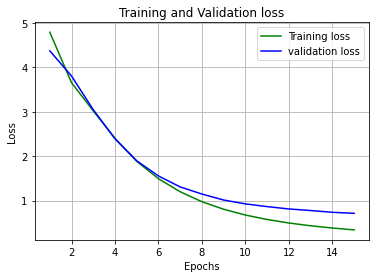

In [ ]:
#  training loss vs validation Accuracy
import matplotlib.pyplot as plt

epochs = range(1,16)
plt.plot(epochs, train_l, 'g', label='Training loss')
plt.plot(epochs, test_l, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()